# Flagellar Reaction-Diffusion

The model equations are given in non-dimensional form by

\begin{align}
    \mu_a \zeta \bar{n} \gamma_t &= \gamma_{ss} - \mu \gamma + \mu_a \tilde{n}\\
    n^+_t &= \eta(1 - n^+) - (1-\eta)n^+ e^{f^\ast (1+ \zeta \gamma_t)} \\
    n^-_t &= \eta(1 - n^+) - (1-\eta)n^- e^{f^\ast (1 - \zeta \gamma_t)}
\end{align}

with boundary conditions $\gamma(0) = 0$, $\gamma_s(0)=1$.

In [1]:
from numpy import *
from scipy.linalg import toeplitz
from scipy.integrate import solve_ivp
from scipy.sparse import bmat, eye
import matplotlib.pyplot as plt

n = 100    # discrete segments of arclength
fstar = 2  # detachment force ratio

S = n**2*toeplitz(pad([-2,1], (0,n-1)))    # second derivative matrix
I = eye(n+1)   # identity matrix

s = linspace(0,1,n+1)   # points of arclength
ds = s[1]
t_sub = 20   # subdivide unit of time by t_sub

c:\Users\jc4196\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def rd(t, X, mu_a, mu, eta, zeta):    # right hand side of the system
    gamma = X[:n+1]
    nplus = maximum(X[n+1:2*n+2], 0)    # prevent motor populations from becoming negative
    nminus = maximum(X[2*n+2:], 0)

    gamma_t = (S @ gamma - mu*gamma + mu_a*(nminus - nplus))/(mu_a*zeta*(nplus + nminus))

    # apply boundary conditions
    gamma_t[0] = -gamma[0]
    gamma_t[n] = n**2*(2*gamma[n-1] - 2*gamma[n]) - mu*gamma[n] + mu_a*(nminus[n] - nplus[n])
    gamma_t[n] /= mu_a*zeta*(nplus[n] + nminus[n])

    nplus_t = eta*(1 - nplus) - (1-eta)*nplus*exp(fstar*(1 + zeta*gamma_t)) 
    nminus_t = eta*(1 - nminus) - (1-eta)*nminus*exp(fstar*(1 - zeta*gamma_t))

    return concatenate((gamma_t, nplus_t, nminus_t))    

In [3]:
def solve_rd(T, mu_a, mu, eta, zeta):
    b = eta + (1-eta)*exp(fstar)
    n0 = eta/b
    x0 = concatenate((0.0015*exp(-(s-0.5)**2/0.1**2), full(2*n+2, n0))) # small gaussian initial condition
    
    sol = solve_ivp(lambda t, X: rd(t, X, mu_a, mu, eta, zeta),
                    [0,T],
                    x0,
                    t_eval=linspace(0,T,T*t_sub+1),
                    method='BDF',
                    jac_sparsity=bmat([[S,I,I],[S,I,I],[S,I,I]]))
    return sol.t, sol.y[:n+1], sol.y[n+1:2*n+2], sol.y[2*n+2:]

In [4]:
#  Change parameter values here 
T = 100        # final time
mu_a = 2500    # works for mu_a approximately up to 5000
mu = 100
eta = 0.14
zeta = 0.3

t, gamma, nplus, nminus = solve_rd(T, mu_a, mu, eta, zeta)   # solve the system

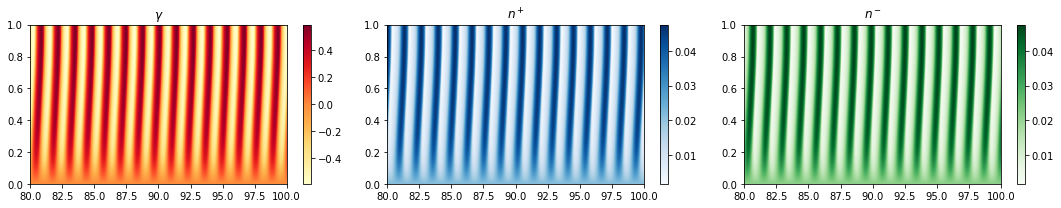

In [5]:
## Plot heatmaps of gamma, nplus, nminus

fig, ax = plt.subplots(1,3, figsize=(15, 3))

def heatmap(x, t_range, ax, cmap=None): 
    t1, t2 = t_range[0]*t_sub, t_range[1]*t_sub
    im = ax.imshow(x[:,t1:t2], origin='lower', aspect='auto', extent=[*t_range, 0, 1], cmap=cmap) 
    fig.colorbar(im, ax=ax)

heatmap(gamma,  [80,100], ax[0], 'YlOrRd')
heatmap(nplus,  [80,100], ax[1], 'Blues')
heatmap(nminus, [80,100], ax[2], 'Greens')

for i, title in enumerate([r'$\gamma$', r'$n^+$', r'$n^-$']): ax[i].set(title=title)
fig.tight_layout()

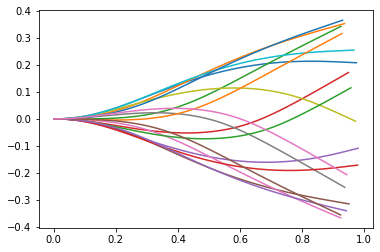

In [6]:
## Plot beating cycle

fig, ax = plt.subplots()
# calculate x,y in head frame
x = pad(cumsum(ds*cos(gamma), axis=0), [(1,0),(0,0)])
y = pad(cumsum(ds*sin(gamma), axis=0), [(1,0),(0,0)])
ax.plot(x[:,-50::3], y[:,-50::3]);